In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import time

def start_timer():
    global start_time
    start_time = time.time()
    print(f"Timer started at {time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(start_time))}")

def stop_timer():
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Timer stopped at {time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(end_time))}")
    print(f"Elapsed time: {elapsed_time} seconds")

In [3]:
start_timer()

# Standard library imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import json
import random
import warnings
import itertools

# Data manipulation and scientific computing
import numpy as np
import pandas as pd
from scipy import stats

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and neural network libraries
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (BatchNormalization, Bidirectional, Conv1D,
                                     Dense, Dropout, LSTM, MaxPooling1D, Activation,
                                     AveragePooling1D, Concatenate, LayerNormalization,
                                     Add, Lambda, Flatten, Layer)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Model evaluation metrics
from sklearn.metrics import (confusion_matrix, f1_score, recall_score,
                             precision_score, accuracy_score, classification_report)
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV

# Filter out all warnings
warnings.filterwarnings("ignore")

# Disable TensorFlow warnings
tf.get_logger().setLevel('ERROR')




Timer started at 2024-06-03 18:17:39


[['Stand', 'Talk-stand'], ['Stand', 'Pick'], ['Stand', 'Jump'], ['Stand', 'Walk'], ['Stand', 'Walk-backward'], ['Stand', 'Walk-circle'], ['Stand', 'Run'], ['Stand', 'Stair-up'], ['Stand', 'Stair-down'], ['Stand', 'Table-tennis'], ['Sit', 'Talk-sit'], ['Talk-sit', 'Sit'], ['Talk-stand', 'Stand'], ['Talk-stand', 'Pick'], ['Talk-stand', 'Jump'], ['Talk-stand', 'Walk'], ['Talk-stand', 'Walk-backward'], ['Talk-stand', 'Walk-circle'], ['Talk-stand', 'Run'], ['Talk-stand', 'Stair-up'], ['Talk-stand', 'Stair-down'], ['Talk-stand', 'Table-tennis'], ['Lay', 'Sit-up'], ['Pick', 'Stand'], ['Pick', 'Talk-stand'], ['Pick', 'Jump'], ['Pick', 'Walk'], ['Pick', 'Walk-backward'], ['Pick', 'Walk-circle'], ['Pick', 'Run'], ['Pick', 'Stair-up'], ['Pick', 'Stair-down'], ['Pick', 'Table-tennis'], ['Jump', 'Stand'], ['Jump', 'Talk-stand'], ['Jump', 'Pick'], ['Jump', 'Walk'], ['Jump', 'Walk-backward'], ['Jump', 'Walk-circle'], ['Jump', 'Run'], ['Jump', 'Stair-up'], ['Jump', 'Stair-down'], ['Jump', 'Table-tenni

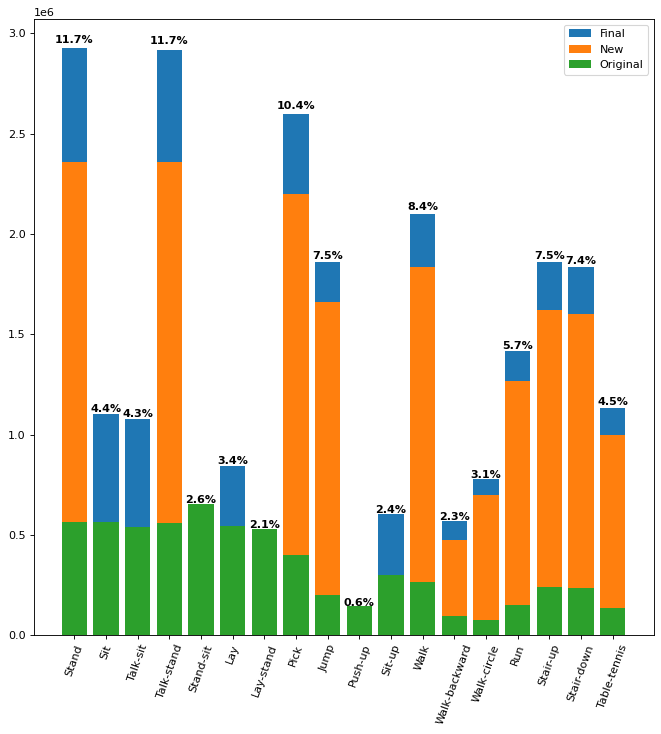

In [4]:
# Data Augmentation Code

def show_signals(data):
    Accelerometer_X_axis_data = data[:, 0]
    Accelerometer_Y_axis_data = data[:, 1]
    Accelerometer_Z_axis_data = data[:, 2]
    Gyroscope_X_axis_data = data[:, 3]
    Gyroscope_Y_axis_data = data[:, 4]
    Gyroscope_Z_axis_data = data[:, 5]
    time = np.linspace(0.01, data.shape[0] / 100, data.shape[0])

    plt.figure(figsize=(20, 10), dpi=80)

    ax1 = plt.subplot(231)
    ax1.plot(time, Accelerometer_X_axis_data, "b")
    ax1.title.set_text(f"Accelerometer X axis")
    ax1.set_xlabel("time (s) ->")
    ax1.set_ylabel("Acceleration (m/s^2)")
    ax1.grid(True)

    ax2 = plt.subplot(232)
    ax2.plot(time, Accelerometer_Y_axis_data, "g")
    ax2.title.set_text(f"Accelerometer Y axis")
    ax2.set_xlabel("time (s) ->")
    ax2.set_ylabel("Acceleration (m/s^2)")
    ax2.grid(True)

    ax3 = plt.subplot(233)
    ax3.plot(time, Accelerometer_Z_axis_data, "r")
    ax3.title.set_text(f"Accelerometer Z axis")
    ax3.set_xlabel("time (s) ->")
    ax3.set_ylabel("Acceleration (m/s^2)")
    ax3.grid(True)

    ax4 = plt.subplot(234)
    ax4.plot(time, Gyroscope_X_axis_data, "b")
    ax4.title.set_text(f"Gyroscope X axis")
    ax4.set_xlabel("time (s) ->")
    ax4.set_ylabel("Angular rotation (rad/s)")
    ax4.grid(True)

    ax5 = plt.subplot(235)
    ax5.plot(time, Gyroscope_Y_axis_data, "g")
    ax5.title.set_text(f"Gyroscope Y axis")
    ax5.set_xlabel("time (s) ->")
    ax5.set_ylabel("Angular rotation (rad/s)")
    ax5.grid(True)

    ax6 = plt.subplot(236)
    ax6.plot(time, Gyroscope_Z_axis_data, "r")
    ax6.title.set_text(f"Gyroscope Z axis")
    ax6.set_xlabel("time (s) ->")
    ax6.set_ylabel("Angular rotation (rad/s)")
    ax6.grid(True)

    plt.show()

f = open("/content/drive/MyDrive/KU-HAR/data_augmentation_KU-HAR.txt", "r")
all_lines = f.readlines()

pairs = []

for line in all_lines:
    line = line.rstrip().split(" ")

    # store pairs
    pairs.append([line[0], line[-1]])

print(pairs, "\n")
print("Num. of samples: ", len(pairs))

CLASS_LABELS = np.array([
    "Stand", "Sit", "Talk-sit", "Talk-stand", "Stand-sit", "Lay", "Lay-stand", "Pick", "Jump", "Push-up",
    "Sit-up", "Walk", "Walk-backward", "Walk-circle", "Run", "Stair-up", "Stair-down", "Table-tennis"
])

df = pd.read_csv("/content/drive/MyDrive/KU-HAR/KU-HAR_time_domain_subsamples_20750x300.csv", header=None)

signals = df.values[:, 0:1800]
signals = np.array(signals, dtype=np.float32)
labels = df.values[:, 1800]
labels = np.array(labels, dtype=np.int64)

print(signals.shape, labels.shape, "\n")

# Remove broken samples in original dataset
indexes = [6587, 6588, 6589, 6590, 6591, 6592, 6593, 6594, 6595, 6596, 6597, 6598, 6599, 6600, 6601, 6602, 6603, 6604,
           6605, 6606, 6607, 6660, 6661, 6662, 6663, 6664, 6665, 6666, 6667, 6668, 6669, 6670, 6671, 6672, 6673, 6674,
           6675, 6676, 6677, 6678, 6679, 6680, 6681, 6682, 6683, 6684, 6685, 6686, 6687, 6716, 6717, 6718, 6719, 6720,
           6721, 6722, 6723, 6724, 6725, 6726, 6727, 6728, 6729, 6730, 6731, 6732, 6733, 6734, 6735, 6736, 6737, 6738,
           6739, 6740, 6741, 6742, 6743, 6750, 6751, 6752, 6753, 6754, 6755, 6756, 6757, 6758, 6759, 6760, 6761, 6762,
           6763, 6764, 6765, 6766, 6767]

# delete the broken samples
signals = np.delete(signals, indexes, 0)
labels = np.delete(labels, indexes, 0)

signals = np.stack([
    signals[:, 0:300],    # ACC X
    signals[:, 300:600],  # ACC Y
    signals[:, 600:900],  # ACC Z
    signals[:, 900:1200],  # GYRO X
    signals[:, 1200:1500],  # GYRO Y
    signals[:, 1500:1800],  # GYRO Z
], axis=-1)

labels = np.repeat(labels.reshape(labels.shape[0], 1), signals.shape[1], axis=1)

print("Mean:", np.mean(signals, axis=(0, 1)))
print("Std:", np.std(signals, axis=(0, 1)))
print("Max:", np.max(signals, axis=(0, 1)))
print("Min:", np.min(signals, axis=(0, 1)), "\n")

print(signals.shape, labels.shape, "\n")

new_signals = []
new_labels = []

for i in range(len(pairs)):
    print("Working on ", i, "sample")

    first = np.where(CLASS_LABELS == pairs[i][0])[0]
    second = np.where(CLASS_LABELS == pairs[i][1])[0]

    first_indexes = np.unique(np.where(labels == first)[0])
    second_indexes = np.unique(np.where(labels == second)[0])

    # Minimum for creating absolutely non-duplicate examples - prevention of overfit
    count = min(first_indexes.shape[0], second_indexes.shape[0])

    merged_signals = np.concatenate(
        (signals[first_indexes[:count]], signals[second_indexes[:count]]), axis=1
    )

    merged_labels = np.concatenate(
        (labels[first_indexes[:count]], labels[second_indexes[:count]]), axis=1
    )

    downsample_signals = merged_signals[:, ::2, :]
    new_signals.append(downsample_signals)

    downsample_labels = merged_labels[:, ::2]
    new_labels.append(downsample_labels)

# Merge all pairs into batch axis
new_signals = np.concatenate(new_signals, axis=0)
new_labels = np.concatenate(new_labels, axis=0)

# Merge all pairs into batch axis
final_signals = np.concatenate([signals, new_signals], axis=0)
final_labels = np.concatenate([labels, new_labels], axis=0)


print("Mean:", np.mean(final_signals, axis=(0, 1)))
print("Std:", np.std(final_signals, axis=(0, 1)))
print("Max:", np.max(final_signals, axis=(0, 1)))
print("Min:", np.min(final_signals, axis=(0, 1)), "\n")

print(final_signals.shape, final_labels.shape)

# Visualize labels distribution
plt.figure(figsize=(10, 10), dpi=80)

total_counts = final_labels.shape[0] * final_labels.shape[1]
unique, final_counts = np.unique(final_labels, return_counts=True)
chart = plt.bar(CLASS_LABELS[unique], final_counts)
plt.xticks(rotation=70)

unique, counts = np.unique(new_labels, return_counts=True)
plt.bar(CLASS_LABELS[unique], counts)
plt.xticks(rotation=70)

unique, counts = np.unique(labels, return_counts=True)
plt.bar(CLASS_LABELS[unique], counts)
plt.xticks(rotation=70)

for i, p in enumerate(chart):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x + width / 2,
             y + height * 1.01,
             str(round((final_counts[i] * 100) / total_counts, 1)) + '%',
             ha='center',
             weight='bold')

plt.legend(["Final", "New", "Original"])
plt.show()

np.savez_compressed("new_dataset", signals=final_signals, labels=final_labels)


In [5]:
# Load the dataset
dataset = np.load("new_dataset.npz")

# Separate signals and labels
signals = dataset['signals']
labels = dataset['labels']

# Print the number of columns in the signals array
num_columns = signals.shape[2]
print("Number of columns in the signals array:", num_columns)

# Separate accelerometer and gyroscope data
x_acc = signals[:, :, :3]  # Extract accelerometer data (first three columns)
x_gyro = signals[:, :, 3:]  # Extract gyroscope data (last three columns)

# Split the dataset into train and test sets
x_acc_train, x_acc_test, y_train, y_test = train_test_split(x_acc, labels, test_size=0.2, random_state=42)
x_gyro_train, x_gyro_test, _, _ = train_test_split(x_gyro, labels, test_size=0.2, random_state=42)

# Print shapes to verify
print("x_acc_train shape:", x_acc_train.shape)
print("x_gyro_train shape:", x_gyro_train.shape)
print("x_acc_test shape:", x_acc_test.shape)
print("x_gyro_test shape:", x_gyro_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# One-hot encode the target data
y_train_encoded = to_categorical(y_train, num_classes=18)
y_test_encoded = to_categorical(y_test, num_classes=18)

# Reshape the target data to match the output shape of the model
y_train_reshaped = y_train_encoded[:, 0, :]
y_test_reshaped = y_test_encoded[:, 0, :]

model_save_path = '/content/drive/MyDrive/KU-HAR/RESBLSTM_SWISH_KUHAR.hdf5'


Number of columns in the signals array: 6
x_acc_train shape: (66503, 300, 3)
x_gyro_train shape: (66503, 300, 3)
x_acc_test shape: (16626, 300, 3)
x_gyro_test shape: (16626, 300, 3)
y_train shape: (66503, 300)
y_test shape: (16626, 300)


# **Define the Attention Model**


In [6]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')
        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)
        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'step_dim': self.step_dim,
            'W_regularizer': self.W_regularizer,
            'b_regularizer': self.b_regularizer,
            'W_constraint': self.W_constraint,
            'b_constraint': self.b_constraint,
            'bias': self.bias,
        })
        return config

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a

        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim




#**Define the Model Structure**


In [7]:
class ResBLSTMAttentionModel:

    def __init__(self, learning_rate, batch_size):
        self.model = None
        self.learning_rate = learning_rate
        self.batch_size = batch_size

    def ResBLSTM_Attention(self, input):
        model = Conv1D(256, 3, input_shape=(128, 3), activation='swish', padding='same')(input)
        model = BatchNormalization()(model)
        model = MaxPooling1D(pool_size=2)(model)
        model = Dropout(0.2)(model)

        model = Conv1D(256//2, 3, activation='swish', padding='same')(model)
        model = BatchNormalization()(model)
        model = MaxPooling1D(pool_size=2)(model)
        model = Dropout(0.2)(model)

        model = Conv1D(256//4, 3, activation='swish', padding='same')(model)
        model = BatchNormalization()(model)
        model = MaxPooling1D(pool_size=2)(model)
        model = Dropout(0.2)(model)

        model = Conv1D(256//8, 3, activation='swish', padding='same')(model)
        model = BatchNormalization()(model)
        model = MaxPooling1D(pool_size=2)(model)
        model = Dropout(0.2)(model)

        model = LayerNormalization()(model)

        x = Bidirectional(LSTM(64, return_sequences=True))(model)
        model = LayerNormalization()(x)
        y = Bidirectional(LSTM(64, return_sequences=True))(model)

        model = Add()([x, y])

        output = Attention(18)(model)

        return output


    def create_model(self, learning_rate, batch_size):
        # Define the input layers
        input_1 = Input(shape=(300, 3))
        input_2 = Input(shape=(300, 3))



        model1 = self.ResBLSTM_Attention(input_1)
        model2 = self.ResBLSTM_Attention(input_2)


        concatenated_models = Concatenate()([model1, model2])

        output = Dropout(0.3)(concatenated_models)
        output = Dense(18)(output)
        output = Activation('softmax', name="softmax")(output)
        self.model = Model(inputs=[input_1, input_2], outputs=output)
        self.model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Nadam(learning_rate=learning_rate),metrics=['accuracy'] )

    def fit(self, X, y, learning_rate, batch_size, epochs, validation_data, early_stopping):

        self.create_model(learning_rate, batch_size)

        # Callbacks
        callbacks = []

        if early_stopping:
            callbacks.append(EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True))

        callbacks.append(ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1))

        # Training the model with validation
        history = self.model.fit(
        X, y,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=validation_data,
        callbacks=callbacks)

        return history


    def fit2(self, X, y, learning_rate, batch_size, epochs, validation_data):
        self.create_model(learning_rate, batch_size)

        # Callbacks
        callbacks = []
        callbacks.append(EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='max', restore_best_weights=True))
        callbacks.append(ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1))

        # Training the model with validation
        history = self.model.fit(
             X, y,
             batch_size=batch_size,
             epochs=epochs,
             verbose=1,
             validation_data=validation_data,
             callbacks=callbacks
         )
        return history



    def get_params(self, deep=True):
        return {
            'learning_rate': self.learning_rate,
            'batch_size': self.batch_size
        }


    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

Epoch 1/150
1663/1663 [==============================] - ETA: 0s - loss: 0.4930 - accuracy: 0.8219
Epoch 1: val_accuracy improved from -inf to 0.87159, saving model to /content/drive/MyDrive/KU-HAR/RESBLSTM_SWISH_KUHAR.hdf5
1663/1663 [==============================] - 119s 51ms/step - loss: 0.4930 - accuracy: 0.8219 - val_loss: 0.3110 - val_accuracy: 0.8716
Epoch 2/150
1662/1663 [============================>.] - ETA: 0s - loss: 0.2674 - accuracy: 0.8977
Epoch 2: val_accuracy improved from 0.87159 to 0.90031, saving model to /content/drive/MyDrive/KU-HAR/RESBLSTM_SWISH_KUHAR.hdf5
1663/1663 [==============================] - 79s 47ms/step - loss: 0.2674 - accuracy: 0.8977 - val_loss: 0.2857 - val_accuracy: 0.9003
Epoch 3/150
1663/1663 [==============================] - ETA: 0s - loss: 0.2110 - accuracy: 0.9185
Epoch 3: val_accuracy did not improve from 0.90031
1663/1663 [==============================] - 80s 48ms/step - loss: 0.2110 - accuracy: 0.9185 - val_loss: 0.2865 - val_accuracy: 

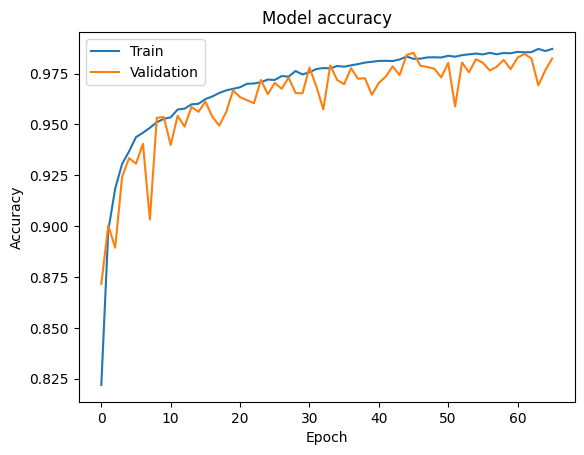

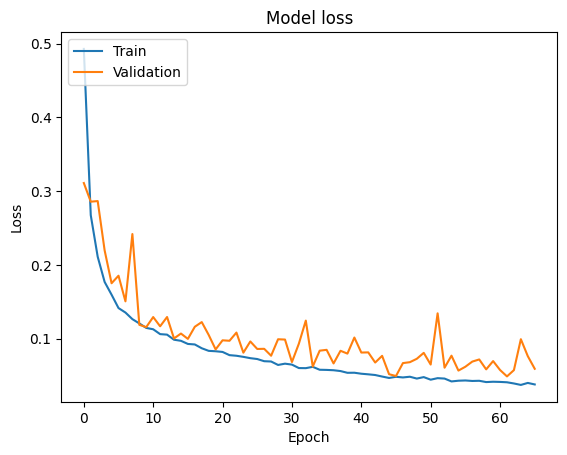

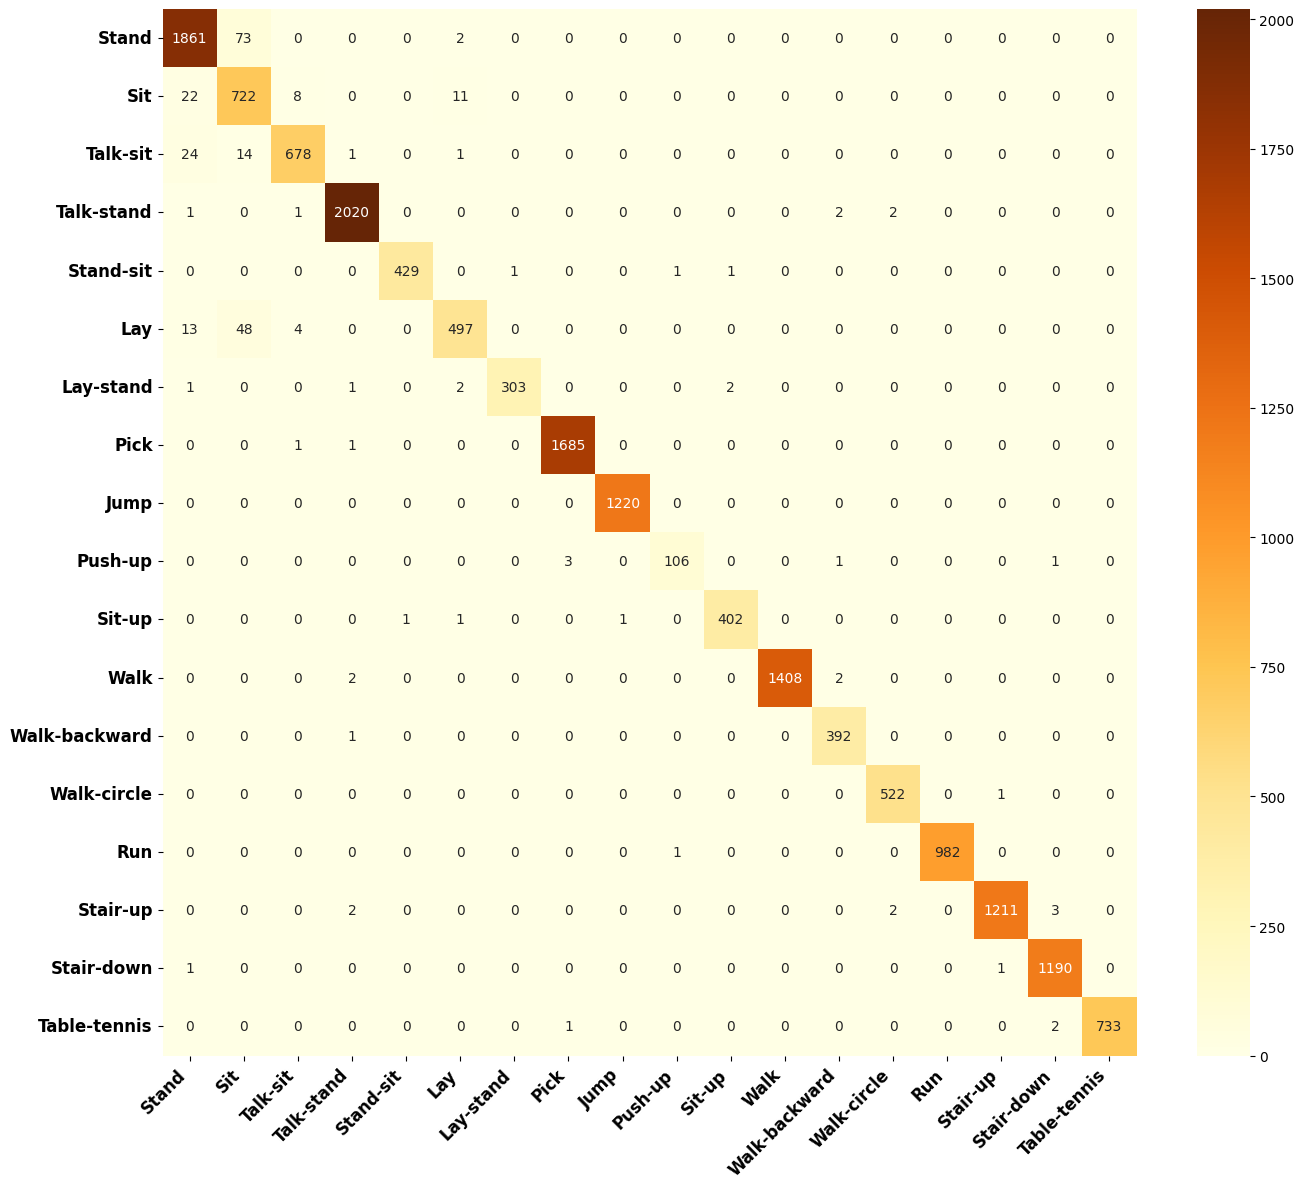

Metrics for Stand:
  True Positives (TP): 1861
  True Negatives (TN): 14628
  False Positives (FP): 62
  False Negatives (FN): 75

Metrics for Sit:
  True Positives (TP): 722
  True Negatives (TN): 15728
  False Positives (FP): 135
  False Negatives (FN): 41

Metrics for Talk-sit:
  True Positives (TP): 678
  True Negatives (TN): 15894
  False Positives (FP): 14
  False Negatives (FN): 40

Metrics for Talk-stand:
  True Positives (TP): 2020
  True Negatives (TN): 14592
  False Positives (FP): 8
  False Negatives (FN): 6

Metrics for Stand-sit:
  True Positives (TP): 429
  True Negatives (TN): 16193
  False Positives (FP): 1
  False Negatives (FN): 3

Metrics for Lay:
  True Positives (TP): 497
  True Negatives (TN): 16047
  False Positives (FP): 17
  False Negatives (FN): 65

Metrics for Lay-stand:
  True Positives (TP): 303
  True Negatives (TN): 16316
  False Positives (FP): 1
  False Negatives (FN): 6

Metrics for Pick:
  True Positives (TP): 1685
  True Negatives (TN): 14935
  Fals

In [8]:


best_params = {
    'learning_rate': 0.001,
    'batch_size': 32
}

# Reserve a portion of the training data for validation
x_train_final, x_val_final, y_train_final, y_val_final = train_test_split(
    np.concatenate([x_acc_train, x_gyro_train], axis=-1),
    y_train_reshaped,
    test_size=0.2,
    random_state=42
)

# Train the final model using the best hyperparameters
best_model = ResBLSTMAttentionModel(learning_rate=best_params['learning_rate'], batch_size=best_params['batch_size'])


# Fit the model to the training data with validation data
history = best_model.fit2(
     X=[
        x_train_final[:, :, :3],  # Original body acceleration data for the final model
        x_train_final[:, :, 3:],  # Original body gyro data for the final model
    ],
    y=y_train_final,
    learning_rate=best_params['learning_rate'],
    batch_size=best_params['batch_size'],
    epochs=150,
    validation_data=(
        [
            x_val_final[:, :, :3],  # Original validation body acceleration data
            x_val_final[:, :, 3:],  # Original validation body gyro data
        ],
        y_val_final
    )
)

# Evaluate the model on the test data
test_loss, test_accuracy = best_model.model.evaluate([x_acc_test,
                                                      x_gyro_test],
                                                    y_test_reshaped, verbose=0)

# Calculate additional evaluation metrics
y_pred = best_model.model.predict([x_acc_test,
                                   x_gyro_test])

y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax( y_test_reshaped, axis=1)

# Calculate various precision, recall, and F1 scores
precision_macro = precision_score(y_true_labels, y_pred_labels, average='macro')
precision_weighted = precision_score(y_true_labels, y_pred_labels, average='weighted')
precision_micro = precision_score(y_true_labels, y_pred_labels, average='micro')

recall_macro = recall_score(y_true_labels, y_pred_labels, average='macro')
recall_weighted = recall_score(y_true_labels, y_pred_labels, average='weighted')
recall_micro = recall_score(y_true_labels, y_pred_labels, average='micro')

f1_macro = f1_score(y_true_labels, y_pred_labels, average='macro')
f1_weighted = f1_score(y_true_labels, y_pred_labels, average='weighted')
f1_micro = f1_score(y_true_labels, y_pred_labels, average='micro')

accuracy = accuracy_score(y_true_labels, y_pred_labels)

# Calculate per-class accuracy
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Calculate macro accuracy
macro_accuracy = per_class_accuracy.mean()

# Calculate weighted accuracy
weighted_accuracy = np.average(per_class_accuracy, weights=np.bincount(y_true_labels))

population_std_dev_true = np.std(y_true_labels, ddof=0)
population_std_dev_pred = np.std(y_pred_labels, ddof=0)

sample_std_dev_true = np.std(y_true_labels, ddof=1)
sample_std_dev_pred = np.std(y_pred_labels, ddof=1)


# Print model summary
best_model.model.summary()

# Print evaluation metrics
average_accuracy = np.mean(history.history['accuracy'])
best_accuracy = np.max(history.history['accuracy'])
last_accuracy = history.history['accuracy'][-1]

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Average Accuracy: {average_accuracy}")
print(f"Best Accuracy: {best_accuracy}")
print(f"Last Epoch Accuracy: {last_accuracy}")

print(f"Micro Accuracy: {accuracy:.4f}")
print(f"Macro Accuracy: {macro_accuracy:.4f}")
print(f"Weighted Accuracy: {weighted_accuracy:.4f}")

print("Precision (Macro):", precision_macro)
print("Precision (Weighted):", precision_weighted)
print("Precision (Micro):", precision_micro)

print("Recall (Macro):", recall_macro)
print("Recall (Weighted):", recall_weighted)
print("Recall (Micro):", recall_micro)

print("F1 Score (Macro):", f1_macro)
print("F1 Score (Weighted):", f1_weighted)
print("F1 Score (Micro):", f1_micro)

print("Population Std Dev - True Labels:", population_std_dev_true)
print("Population Std Dev - Predicted Labels:", population_std_dev_pred)
print("Sample Std Dev - True Labels:", sample_std_dev_true)
print("Sample Std Dev - Predicted Labels:", sample_std_dev_pred)
print("_______________________________________________________________\n")


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

class_labels = ["Stand", "Sit", "Talk-sit", "Talk-stand", "Stand-sit", "Lay", "Lay-stand", "Pick",
                "Jump", "Push-up", "Sit-up", "Walk", "Walk-backward", "Walk-circle", "Run", "Stair-up",
                "Stair-down","Table-tennis"]

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels, labels=range(len(class_labels)))
cm = pd.DataFrame(conf_matrix, columns=class_labels, index=class_labels)

# Plot the confusion matrix heatmap with adjusted annotation size and label size
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(cm, cmap="YlOrBr", fmt="d", annot=True, annot_kws={"size": 10}, cbar=True)
plt.yticks(rotation=0, fontsize=12, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

# Calculate TP, TN, FP, FN for each class
def calculate_confusion_metrics(conf_matrix):
    TP = np.diag(conf_matrix)  # True Positives are on the diagonal
    FP = np.sum(conf_matrix, axis=0) - TP  # False Positives are column sums minus TP
    FN = np.sum(conf_matrix, axis=1) - TP  # False Negatives are row sums minus TP
    TN = conf_matrix.sum() - (FP + FN + TP)  # True Negatives are total sum minus FP, FN, TP

    return TP, TN, FP, FN

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels, labels=range(len(class_labels)))
TP, TN, FP, FN = calculate_confusion_metrics(conf_matrix)

# Print results for each class
for i, class_label in enumerate(class_labels):
    print(f"Metrics for {class_label}:")
    tp = TP[i] if i < len(TP) else 0
    tn = TN[i] if i < len(TN) else 0
    fp = FP[i] if i < len(FP) else 0
    fn = FN[i] if i < len(FN) else 0
    print(f"  True Positives (TP): {tp}")
    print(f"  True Negatives (TN): {tn}")
    print(f"  False Positives (FP): {fp}")
    print(f"  False Negatives (FN): {fn}\n")

stop_timer()